In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from io import BytesIO

import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from google.cloud import bigquery

from data_collector import BQManager, GCP, Omie, MarginalPriceParams, OfferCurvesParams, OfferCurvesUnitsParams

## Upload tables to BigQuery

In [ ]:
job_config = bigquery.job.LoadJobConfig()
job_config.autodetect = True
job_config.create_disposition = bigquery.job.CreateDisposition.CREATE_IF_NEEDED
job_config.write_disposition = bigquery.job.WriteDisposition.WRITE_APPEND

years = range(2016, 2022)

for year in years:
    print("="*15  + f" {year} " + "="*15)
    Omie.upload_bq_year_file(omie_parameter=OfferCurvesUnitsParams, year=year, job_config=job_config)

In [ ]:
job_config = bigquery.job.LoadJobConfig()
job_config.autodetect = True
job_config.create_disposition = bigquery.job.CreateDisposition.CREATE_IF_NEEDED
job_config.write_disposition = bigquery.job.WriteDisposition.WRITE_APPEND


dates = pd.date_range(start="2021-01-01", end="2022-02-19", freq="D")
_ = Parallel(n_jobs=-1)(
    delayed(Omie.upload_bq_date_file)(omie_parameter=OfferCurvesParams, date=date, job_config=job_config)
    for date in dates
)

## Generate hourly tables

In [3]:
client = bigquery.Client(GCP.PROJECT_ID)
bq_manager = BQManager(client=client)

In [ ]:
bq_manager.generate_hourly_offer_curve_tables(curve_parameter=OfferCurvesUnitsParams, 
                                             offer_status=OfferCurvesUnitsParams.OfferStatus.offered)

## Download table

In [4]:
df = bq_manager.download_query_to_df(
    query=f"SELECT * FROM {GCP.BigQuery.Omie.DATASET_ID}.{GCP.BigQuery.Omie.OFFER_CURVES_UNITS_TABLE_ID}_{2}"
)

Downloading:   0%|          | 0/3475532 [00:00<?, ?rows/s]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3475532 entries, 0 to 3475531
Data columns (total 8 columns):
 #   Column      Dtype              
---  ------      -----              
 0   hour        int64              
 1   date        datetime64[ns, UTC]
 2   country     object             
 3   unit        object             
 4   offer_type  object             
 5   energy      float64            
 6   price       float64            
 7   status      object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(4)
memory usage: 212.1+ MB


In [6]:
df_ask = df[df["offer_type"] == OfferCurvesUnitsParams.OfferType.ask.value]
df_bid = df[df["offer_type"] == OfferCurvesUnitsParams.OfferType.bid.value]

df_ask = df_ask.sort_values(["date", "price"])
df_bid = df_bid.sort_values("date").sort_values("price", ascending=False)

df_ask["agg_energy"] = df_ask.groupby("date")["energy"].transform("cumsum")
df_bid["agg_energy"] = df_bid.groupby("date")["energy"].transform("cumsum")

In [7]:
df_ask_date = df_ask.set_index("date")
df_bid_date = df_bid.set_index("date")

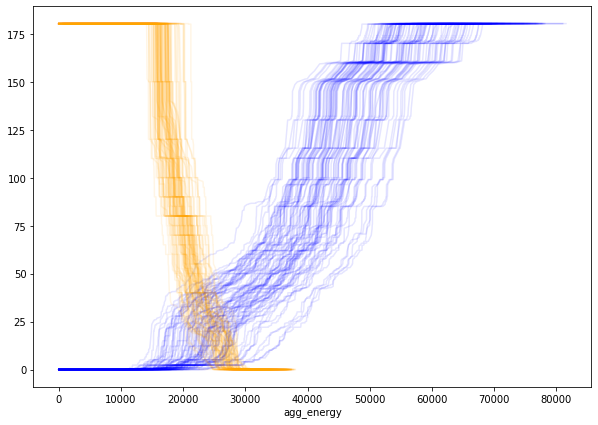

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
for date in pd.date_range(start="2016-01-01", end="2016-04-01", freq="D"):
    df_ask_date.loc[date].plot(x="agg_energy", y="price", ax=ax, label="", color="blue", alpha=0.1)
    df_bid_date.loc[date].plot(x="agg_energy", y="price", ax=ax, label="", color="orange", alpha=0.1)
legend = ax.get_legend()
legend.remove()

<IPython.core.display.Javascript object>


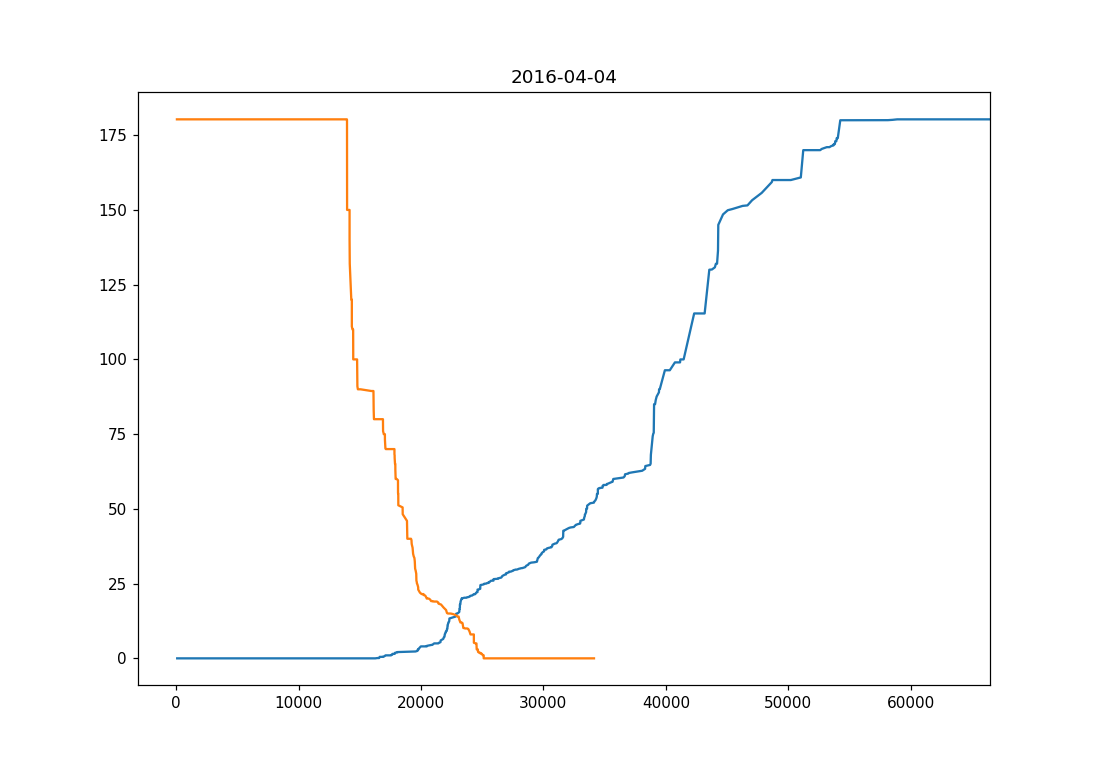

In [9]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(10, 7))

x_ask = df_ask_date.loc["2016-01-01"]["agg_energy"]
y_ask = df_ask_date.loc["2016-01-01"]["price"]
x_bid = df_bid_date.loc["2016-01-01"]["agg_energy"]
y_bid = df_bid_date.loc["2016-01-01"]["price"]
dates = pd.date_range(start="2016-01-01", end="2017-01-01", freq="D")
ask_curve, = ax.plot(x_ask, y_ask)
bid_curve, = ax.plot(x_bid, y_bid)


def animate(i):
    date = dates[i]
    
    ax.set_title(date.strftime("%Y-%m-%d"))
    ask_curve.set_xdata(df_ask_date.loc[date]["agg_energy"].values)
    ask_curve.set_ydata(df_ask_date.loc[date]["price"].values)
    bid_curve.set_xdata(df_bid_date.loc[date]["agg_energy"].values)
    bid_curve.set_ydata(df_bid_date.loc[date]["price"].values)
    
    
    return ask_curve, bid_curve


ani = animation.FuncAnimation(fig, animate, interval=80, blit=False, save_count=90)
#ani.save('curves.gif', writer='imagemagick', fps=10)
plt.show()